<a href="https://colab.research.google.com/github/ahmecse/A-Mathematical-Essay-on-Support-Vector-Machine/blob/main/CS6700_Tutorial_9_DynaQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 9: DynaQ

### Tasks to be done:

1. Complete code for Planning step update. (search for "TODO" marker)
2. Compare the performance (train and test returns) for the following values of planning iterations = **[0, 1, 2, 5, 10]**
3. For each value of planning iteration, average the results on **100 runs** (due to the combined stochasticity in the env, epsilon-greedy and planning steps, we need you to average the results over a larger set of runs)

In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
import tqdm
import random
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt

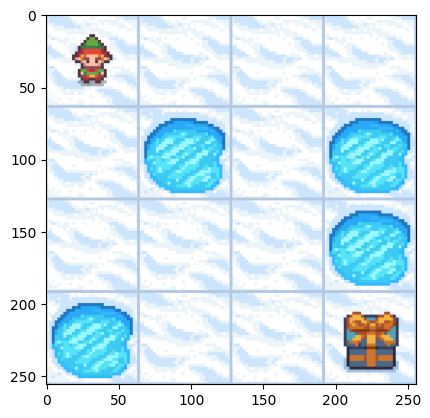

In [ ]:
env = gym.make('FrozenLake-v1', is_slippery = True, render_mode = 'rgb_array')
env.reset()

# https://gymnasium.farama.org/environments/toy_text/frozen_lake

# if pygame is not installed run: "!pip install gymnasium[toy-text]"

plt.imshow(env.render())

In [ ]:
class DynaQ:
    def __init__(self, num_states, num_actions, gamma=0.99, alpha=0.01, epsilon=0.25):
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma  # discount factor
        self.alpha = alpha  # learning rate
        self.epsilon = epsilon  # exploration rate
        self.q_values = np.zeros((num_states, num_actions))  # Q-values
        self.model = {}  # environment model, mapping state-action pairs to next state and reward
        self.visited_states = []  # dictionary to track visited state-action pairs

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_values[state])

    def update_q_values(self, state, action, reward, next_state):
        # Update Q-value using Q-learning
        best_next_action = np.argmax(self.q_values[next_state])
        td_target = reward + self.gamma * self.q_values[next_state][best_next_action]
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error

    def update_model(self, state, action, reward, next_state):
        # Update model with observed transition
        self.model[(state, action)] = (reward, next_state)

    def planning(self, plan_iters):
        for _ in range(plan_iters):
            state, action = self.sample_state_action()
            reward, next_state = self.model[(state, action)]

            best_next_action = np.argmax(self.q_values[next_state])
            td_target = reward + self.gamma * self.q_values[next_state][best_next_action]
            td_error = td_target - self.q_values[state][action]
            self.q_values[state][action] += self.alpha * td_error

    def sample_state_action(self):
        # Sample a state-action pair from the dictionary of visited state-action pairs
        state_action = random.sample(self.visited_states, 1)
        state, action = state_action[0]
        return state, action

    def learn(self, state, action, reward, next_state, plan_iters):
        # Update Q-values, model, and perform planning
        self.update_q_values(state, action, reward, next_state)
        self.update_model(state, action, reward, next_state)

        # Update the visited state-action value
        self.visited_states.append((state, action))
        self.planning(plan_iters)

In [ ]:
class Trainer:
    def __init__(self, env, gamma = 0.99, alpha = 0.01, epsilon = 0.25):
        self.env = env
        self.agent = DynaQ(env.observation_space.n, env.action_space.n, gamma, alpha, epsilon)

    def train(self, num_episodes = 1000, plan_iters = 10):
        # training the agent
        all_returns = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            episodic_return = 0
            while not done:
                action = self.agent.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episodic_return += reward
                self.agent.learn(state, action, reward, next_state, plan_iters)
                state = next_state
                done = terminated or truncated
            all_returns.append(episodic_return)

        return all_returns

    def test(self, num_episodes=500):
        # testing the agent
        all_returns = []
        for episode in range(num_episodes):
            episodic_return = 0
            state, _ = self.env.reset()
            done = False
            while not done:
                action = np.argmax(self.agent.q_values[state]) # Act greedy wrt the q-values
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episodic_return += reward
                state = next_state
                done = terminated or truncated
            all_returns.append(episodic_return)
        return all_returns

In [ ]:
# Example usage:
env = gym.make('FrozenLake-v1', is_slippery = True)
agent = Trainer(env, alpha=0.01, epsilon=0.25)
train_returns = agent.train(num_episodes = 1000, plan_iters = 10)
eval_returns = agent.test(num_episodes = 1000)
print(sum(eval_returns))

30.0


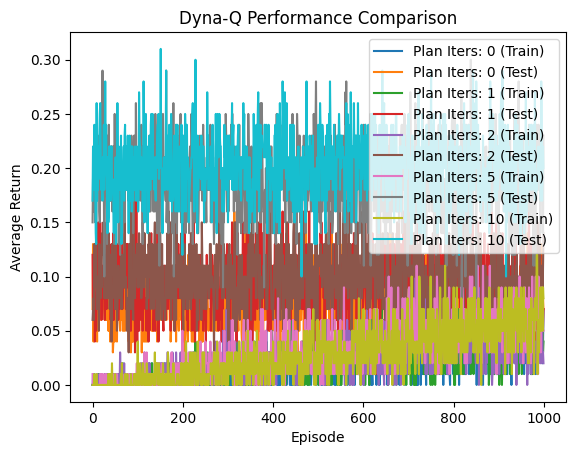

In [ ]:
# Task 2 & 3: Performance Comparison and Averaging
plan_iters_list = [0, 1, 2, 5, 10]
num_runs = 100
results = {}

for pi in plan_iters_list:
    all_train_returns = []
    all_test_returns = []

    for _ in range(num_runs):
        agent = Trainer(env, alpha=0.01, epsilon=0.25)  # Reset agent for each run
        train_returns = agent.train(num_episodes=1000, plan_iters=pi)
        test_returns = agent.test(num_episodes=1000)

        all_train_returns.append(train_returns)
        all_test_returns.append(test_returns)

    results[pi] = {
        'train_returns': all_train_returns,
        'test_returns': all_test_returns
    }


# Analyze and visualize results (example)
for pi, data in results.items():
    avg_train_returns = np.mean(data['train_returns'], axis=0)
    avg_test_returns = np.mean(data['test_returns'], axis=0)

    plt.plot(avg_train_returns, label=f'Plan Iters: {pi} (Train)')
    plt.plot(avg_test_returns, label=f'Plan Iters: {pi} (Test)')

plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.title('Dyna-Q Performance Comparison')
plt.legend()
plt.show()

# Additional Analysis (Optional)
for pi, data in results.items():
  std_train_returns = np.std(data['train_returns'], axis=0)
  std_test_returns = np.std(data['test_returns'], axis=0)

  plt.plot(avg_train_returns, label=f'Plan Iters: {pi} (Train)')
  # Plot with error bars for better analysis
  plt.errorbar(range(len(avg_train_returns)), avg_train_returns, yerr=std_train_returns, fmt='o')

  plt.xlabel('Episode')
  plt.ylabel('Average Return')
  plt.title(f'Dyna-Q Performance Comparison (Planning Iterations: {pi})')
  plt.legend()
  plt.show()

TODO:
- Compare the performance (train and test returns) for the following values of planning iterations = [0, 1, 2, 5, 10]
- For each value of planning iteration, average the results on 100 runs (due to the combined stochasticity in the env, epsilon-greedy and planning steps, we need you to average the results over a larger set of runs)

---

Sample Skeleton Code:

for pi in plan_iter:

&emsp; for 100 times:

&emsp;&emsp; train(pi)

&emsp;&emsp; test()

&emsp; print(avg_performance)